# Style transfering with own example

The orignal work of style transfering with deep learning by Convolutional Neural Network (CNN) is of [Gatys et al (2015)](https://arxiv.org/abs/1508.06576). There are, to my knowledge, two versions of implementation running outside. The first is from TensorFlow Tutorial, and the second is from Coursera. (For the second version, acknowledgement to access is to Mr. Kruitbosch for the Eurostat ESTP course.) 

The second version, making use of functions from MatConvNet Team, is more concise. However, it is not so intuitive and more difficult to implement. In this example, attempt is made to combine these two implementations.

In [1]:
import os
import tensorflow
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
# From RUG University, load the utility functions.
import sys
try:
  from download import download
except ImportError:
  !pip3 install download
  from download import download

download(f'https://datascience.web.rug.nl/nst_utils.py', f'nst_utils.py')


file_sizes: 100%|██████████████████████████| 6.72k/6.72k [00:00<00:00, 2.01MB/s]
Successfully downloaded file to nst_utils.py


'nst_utils.py'

In [3]:
import scipy.io
import scipy.misc
from skimage.io import imread, imsave

# Hack to make nst_utils.py work
scipy.misc.imsave = imsave
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow.compat.v1 as tf

%matplotlib inline

#tf.compat.v1.disable_eager_execution()

# Load the content and style images 

Load own content image and the style image of Monet. Change the default image sizes to the new ones.

In [4]:
content_image = imread("drive/MyDrive/Proj1Art/Yingfu Porträtt.JPG")

In [5]:
# Change the default image height and width.
new_height = 400
new_width = int(new_height*0.618)
CONFIG.IMAGE_HEIGHT = new_height
CONFIG.IMAGE_WIDTH = new_width

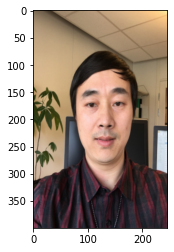

In [6]:
content_image=imresize(content_image, (new_height,new_width,3))
imshow(content_image)

In [ ]:
#content_image[0]

In [7]:
# download the style image of Monet from RUG Uni. 
# download(f'https://datascience.web.rug.nl/monet.jpg', f'monet.jpg')
# or 'kandinsky5.jpg' from GoogleAPIs.
# download(f'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg', f'kandinsky5.jpg')

# or Munch Scream (Skrik)
download(f'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg', f'scream.jpg') 
 


file_sizes: 100%|██████████████████████████| 11.4M/11.4M [00:00<00:00, 27.7MB/s]
Successfully downloaded file to scream.jpg


'scream.jpg'

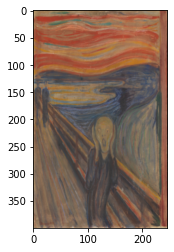

In [8]:
#style_image=imresize(imread("kandinsky5.jpg"), (new_height, new_width,3))
#style_image=imresize(imread("monet.jpg"), (new_height, new_width,3))
style_image=imresize(imread("scream.jpg"), (new_height, new_width,3))

imshow(style_image)

Note that the purpose is to use the **Style** of the style image and apply it to the content image, not simply the style image. Otherwise, one may only take average of these two images and create a new one. 

In [ ]:
mixed_image= (content_image+style_image)/2

In [ ]:
scipy.misc.imsave("mixed_image.jpg", mixed_image)

# Compute the cost function

The algorithm is, for the target image, to minimize the divergence to the content image as well to the "Style" from the style image (not style image self). Please see the tutorial at TensorFlow for details of the cost functions (https://www.tensorflow.org/tutorials/generative/style_transfer).

First, define a cost function for the content image.

In [9]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    # m, n_H, n_W, n_C = list(a_G.shape)
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=(m, n_H*n_W, n_C))
    a_G_unrolled = tf.reshape(a_G, shape=(m, n_H*n_W, n_C))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.math.reduce_sum((a_C_unrolled-a_G_unrolled)**2)/(4*n_H*n_W*n_C)
    # Test not to have the standardized term /(4*n_H*n_W*n_C)
    
    return J_content

In [10]:
# Test this cost function
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 50, 30, 512], mean=1, stddev=4)
    a_G = tf.random_normal([1, 50, 30, 512], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
    J_content_0 = compute_content_cost(a_C, a_C)
    print("Content cost with itself: " + str(J_content_0.eval()))

J_content = 8.013965
Content cost with itself: 0.0


Next, define a style cost. Please see the reference for details.

In [11]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.linalg.matmul(A, A, transpose_b=True)

    return GA

In [12]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost 
    """

    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = list(a_G.shape)
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)  
    a_S_unrolled = tf.reshape(a_S, shape=[n_C, n_H*n_W])
    a_G_unrolled = tf.reshape(a_G, shape=[n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G  
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)

    # Computing the loss  
    J_style_layer = tf.math.reduce_sum((GS-GG)**2)/(4*n_C**2*n_H**2*n_W**2)
    # Test not to have the standardized term /(4*n_C**2*n_H**2*n_W**2)
    
    return J_style_layer

In [13]:
# the size of the standarized term
print(4*(new_height*new_width)**2)

39045760000


In [14]:
# Test the style cost function
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 25, 15, 512], mean=1, stddev=4)
    a_G = tf.random_normal([1, 25, 15, 512], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 0.38549328


In [15]:
print(8.01/(0.38549*2+0.005927+0.09511+0.023873374)*5)

44.704130284583236


The function `compute_layer_style_cost` calculates the style cost of one layer. It is said that a weighted average of several layers would be better. Load the pretrained vgg19 model next and choose a layer for the content image and other layers as weights. 

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [17]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Suppose we choose the activations from `content_layer` to characterize the content image, and neighbor layers for weighting the style cost.



In [18]:
content_layer = ['block4_conv2'] 

style_layers_weights = [('block5_conv3', 0.2),
                ('block2_conv1', 0.2),
                ('block3_conv1', 0.20), 
                ('block4_conv1', 0.2),
                ('block5_conv1',0.2)]

In [19]:
style_layers, style_weights =map(list, zip(*style_layers_weights))
print("layers for style: ", style_layers) 
print("and weights are", style_weights)
type(style_layers)
assert sum(style_weights) == 1, "Wrong. The sum of weights should be 1." 

layers for style:  ['block5_conv3', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
and weights are [0.2, 0.2, 0.2, 0.2, 0.2]


In [20]:
def compute_style_cost(style_output, generated_output, weights=style_weights):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_output -- output layers (ndarray) for the style 
    generated_output -- output layers (ndarray) for the generated image
    weights -- weights for weighting the style cost. Note that they should be in 
              same order as the style layers.
    
    Returns: 
    J_style -- tensor representing a scalar value

    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.

    a_S = style_output

    # Set a_G to be the output of the choosen hidden layers.
    a_G = generated_output

    for i, weight in zip(range(len(a_S)), weights):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer

    return J_style

Use the vgg19 model to create the outputs from required layers.

In [21]:
def vgg_layers_output(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(layer).output for layer in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [22]:
style_extractor = vgg_layers_output(style_layers+content_layer)
style_outputs = style_extractor(tf.reshape(style_image, (1, new_height, new_width, 3)))


In [ ]:
# style_outputs[0].numpy()

In [23]:
# Look at the statistics of each layer's output

for name, output in zip(style_layers+content_layer, style_outputs):
  print(f'{name:20s}')
  print("  shape: ", output.shape)
  print("  min: ", tf.reduce_min(output.numpy()))
  print("  max: ", tf.math.reduce_max(output))
  print("  mean: ", tf.math.reduce_mean(output))
  print()

block5_conv3        
  shape:  (1, 25, 15, 512)
  min:  tf.Tensor(0.0, shape=(), dtype=float32)
  max:  tf.Tensor(4.313628, shape=(), dtype=float32)
  mean:  tf.Tensor(0.1339277, shape=(), dtype=float32)

block2_conv1        
  shape:  (1, 200, 123, 128)
  min:  tf.Tensor(0.0, shape=(), dtype=float32)
  max:  tf.Tensor(18.25, shape=(), dtype=float32)
  mean:  tf.Tensor(1.5859953, shape=(), dtype=float32)

block3_conv1        
  shape:  (1, 100, 61, 256)
  min:  tf.Tensor(0.0, shape=(), dtype=float32)
  max:  tf.Tensor(66.071526, shape=(), dtype=float32)
  mean:  tf.Tensor(1.7006916, shape=(), dtype=float32)

block4_conv1        
  shape:  (1, 50, 30, 512)
  min:  tf.Tensor(0.0, shape=(), dtype=float32)
  max:  tf.Tensor(172.43004, shape=(), dtype=float32)
  mean:  tf.Tensor(8.76246, shape=(), dtype=float32)

block5_conv1        
  shape:  (1, 25, 15, 512)
  min:  tf.Tensor(0.0, shape=(), dtype=float32)
  max:  tf.Tensor(26.282759, shape=(), dtype=float32)
  mean:  tf.Tensor(0.54593074,

Define the total cost function as weighted sum of content cost and style cost. The weights can be tuned later if necessary.

In [24]:
content_weight = 1
style_weight = 40

In [25]:
def total_cost(J_content, J_style, alpha = content_weight, beta = style_weight):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style
    

    return J

# Standardize the content, style, and input images

In [26]:
content_image2 = np.reshape(content_image, (1, new_height, new_width, 3))
style_image2 = np.reshape(style_image, (1, new_height, new_width, 3))

In [27]:
# tf.reduce_mean(content_image2)

In [28]:
noise_ratio = 0.7

In [29]:
np.random.seed(4686)
generated_image = (noise_ratio *np.random.uniform(0, 1, (1, new_height, new_width, 3)) + (1-noise_ratio) * content_image2).astype('float32')

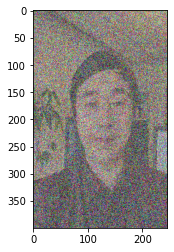

In [30]:
imshow(generated_image[0])

The content and style costs of the standaridized images:

In [31]:
style_target = style_extractor(style_image2)[0:len(style_layers)]
content_target = style_extractor(content_image2)[-1]

In [32]:
image = tf.Variable(generated_image)
#mixed_image2 = (np.reshape(mixed_image,(1, new_height, new_width,3))).astype('float32')
#image = tf.Variable(mixed_image2)
# Start from a saved image.
# image10000 = imread("drive/MyDrive/Proj1Art/image_10000.jpg")
# image10000 = np.reshape(image10000/255, (1, new_height, new_width, 3)).astype('float32')
# image = tf.Variable(image10000)

In [33]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [34]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Define the optimizer and training step 

In [36]:
optimize = tensorflow.optimizers.Adam(learning_rate=1, beta_1=0.99, epsilon=1e-1)

In [37]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = style_extractor(image)
    content_cost = compute_content_cost(content_target,outputs[-1])
    style_cost = compute_style_cost(style_target, outputs[0:len(style_layers)])
    loss = total_cost(content_cost, style_cost)

  grad = tape.gradient(loss, image)
  optimize.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  

In [ ]:
train_step(image)
tensor_to_image(image)


# Run the optimization

In [39]:
epochs = 5001

for i in range(1001, epochs):
    train_step(image)
    if i % 100 == 0:
        print(f"Epoch {i} ")
    if i % 500 == 0:
        savedimage = tensor_to_image(image)
        display.display(savedimage)
        scipy.misc.imsave(f"drive/MyDrive/Proj1Art/image_{i}.jpg", (image[0].numpy()*255).astype('uint8'))      


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
scipy.stats.describe(imread("drive/MyDrive/Proj1Art/image_5000.jpg")- imread("drive/MyDrive/Proj1Art/image_4500.jpg"))

# Conclusion

Using Munsch's Scream (Skrik) as the style image, the learning process is as follows:


In [ ]:
plt.rcParams.keys()

For this original transfer learning algorithm, it takes time to obtain a good result. It is important to choose right parameters (`content_weight, style_weight`, layers for content and style). To standardize the images before (as in the `nst_utils.py`) seems not work well. 